# Training a Jet Tagging with **Recurrent Neural Network** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a GRU unit.
Gated Recurrent Units are one kind of RNNs. 

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [2]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [4]:
! git clone https://github.com/pierinim/tutorials.git

Cloning into 'tutorials'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 8), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (40/40), done.
Checking out files: 100% (20/20), done.


In [6]:
! ls tutorials/HiggsSchool/data

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [7]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/HiggsSchool/data/jetImage_7_100p_30000_40000.h5',
           'tutorials/HiggsSchool/data/jetImage_7_100p_60000_70000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_50000_60000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_10000_20000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
print(target.shape, jetList.shape)

Appending tutorials/HiggsSchool/data/jetImage_7_100p_30000_40000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_60000_70000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_50000_60000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_10000_20000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


The dataset consists of XXX with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


# Building the RNN model

In [13]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, GRU, Dropout
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [14]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [21]:
####
inputList = Input(shape=(featureArrayLength))
x = GRU(40, activation="tanh", recurrent_activation='hard_sigmoid')(inputList)
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 16)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 40)                6840      
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
__________

We now train the model

In [29]:
batch_size = 128
n_epochs = 50

In [ ]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 33500 samples, validate on 16500 samples
Epoch 1/50
 - 16s - loss: 1.3932 - val_loss: 1.3506
Epoch 2/50
 - 16s - loss: 1.3722 - val_loss: 1.3384
Epoch 3/50
 - 16s - loss: 1.3539 - val_loss: 1.3433
Epoch 4/50
 - 17s - loss: 1.3425 - val_loss: 1.3206
Epoch 5/50
 - 19s - loss: 1.3368 - val_loss: 1.3240
Epoch 6/50
 - 17s - loss: 1.3277 - val_loss: 1.3086
Epoch 7/50
 - 16s - loss: 1.3232 - val_loss: 1.3119
Epoch 8/50
 - 16s - loss: 1.3191 - val_loss: 1.3035
Epoch 9/50
 - 16s - loss: 1.3129 - val_loss: 1.3055
Epoch 10/50
 - 17s - loss: 1.3068 - val_loss: 1.2976
Epoch 11/50
 - 16s - loss: 1.3004 - val_loss: 1.2936
Epoch 12/50
 - 18s - loss: 1.2992 - val_loss: 1.3067
Epoch 13/50
 - 16s - loss: 1.2926 - val_loss: 1.2984
Epoch 14/50
 - 16s - loss: 1.2949 - val_loss: 1.2931
Epoch 15/50
 - 16s - loss: 1.2887 - val_loss: 1.2832
Epoch 16/50
 - 16s - loss: 1.2819 - val_loss: 1.2674
Epoch 17/50
 - 16s - loss: 1.2740 - val_loss: 1.2563
Epoch 18/50
 - 16s - loss: 1.2639 - val_loss: 1.2589
Epoch

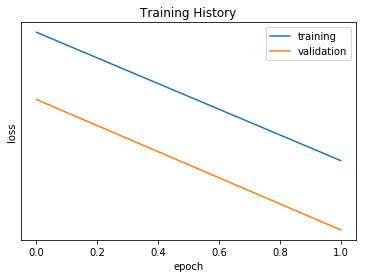

In [27]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

We save on disk the best model, result of the training, to be then use for inference

In [29]:
model_json = model.to_json()
with open("tutorials/HiggsSchool/models/jetTagger_GRU.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("tutorials/HiggsSchool/models/jetTagger_GRU.h5")

# Building the ROC Curves

In [30]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

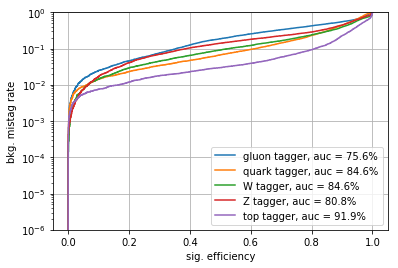

In [31]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()